# Setup

In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [10,6]

train_csv = pd.read_csv('train.csv')
valid_csv = pd.read_csv('dev.csv')

C:\Users\sujeong\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Preliminary Feature Models (not using Review Contents)
Let's try to establish a baseline model which doesn't rely heavily on the review data, since text data requires some fairly heavy data processing.

### Data Processing:
- User review count
- Restaurant review count
- Days since first user review
- Days since first restaurant review
- Review word count
- Review letter count
- Review capitalization count
- Review punctuation count
- Review rating (provided in base dataset)

To avoid leakage, we have to do the *historical* review counts.

In [2]:
def preliminary_feature(data):
    data['user_review_count'] = data.sort_values(['user_id','date']).groupby('user_id')['ex_id'].cumcount()
    data['user_average_rating'] = data.sort_values(['user_id', 'date']).groupby('user_id')['rating'].cumsum() \
                                  / (data['user_review_count'] + 1)
    data['restaurant_review_count'] = data.sort_values(['prod_id', 'date']).groupby('prod_id')['ex_id'].cumcount()
    data['restaurant_average_rating'] = data.sort_values(['prod_id', 'date']).groupby('prod_id')['rating'].cumsum() \
                                        / (data['restaurant_review_count'] + 1)
    data['wordcount'] = data['review'].str.count(" ")
    first_user_review = data.groupby('user_id')['date'].min()
    data['days_since_first_user'] = (pd.to_datetime(data.set_index('user_id')['date']) \
                                     - pd.to_datetime(first_user_review))\
                                    .dt.days.reset_index(drop=True)
    first_restaurant_review = data.groupby('prod_id')['date'].min()
    data['days_since_first_restaurant'] = (pd.to_datetime(data.set_index('prod_id')['date']) \
                                           - pd.to_datetime(first_restaurant_review)) \
                                          .dt.days.reset_index(drop=True)
    data['punctuation_count'] = data['review'].str.count('[,;:!.]')
    data['capitalization_count'] = data['review'].str.count('[A-Z]+')
    data['letter_count'] = data['review'].str.len()
    
    return data

In [3]:
train = preliminary_feature(train_csv)
valid = preliminary_feature(valid_csv)

In [4]:
print(train.columns)

Index(['ex_id', 'user_id', 'prod_id', 'rating', 'label', 'date', 'review',
       'user_review_count', 'user_average_rating', 'restaurant_review_count',
       'restaurant_average_rating', 'wordcount', 'days_since_first_user',
       'days_since_first_restaurant', 'punctuation_count',
       'capitalization_count', 'letter_count'],
      dtype='object')


### Models Trained: 

- Logistic Regression
- XGBoost
- XGBoost with adjustment for class imbalance

In [19]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [17]:
train_features = ['rating', 'user_review_count', 'user_average_rating', 'restaurant_review_count', 
                  'restaurant_average_rating',
                  'punctuation_count', 'wordcount', 'capitalization_count', 'letter_count',
                  'days_since_first_user', 'days_since_first_restaurant']

In [31]:
X_train = train[train_features]
y_train = train['label']

lr = LogisticRegression(max_iter = 800)
lr.fit(X_train, y_train)

tree = XGBClassifier()
tree.fit(X_train, y_train)

tree_balanced = XGBClassifier(scale_pos_weight= (len(y_train)-y_train.sum()) / y_train.sum())
tree_balanced.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=8.716642782447035, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [32]:
train['pred_lr'] = lr.predict_proba(train[train_features])[:,1]
train['pred_tree'] = tree.predict_proba(train[train_features])[:,1]
train['pred_tree_balanced'] = tree_balanced.predict_proba(train[train_features])[:,1]

In [33]:
X_valid = valid[train_features]
y_valid = valid['label']

In [34]:
valid['pred_lr'] = lr.predict_proba(valid[train_features])[:,1]
valid['pred_tree'] = tree.predict_proba(valid[train_features])[:,1]
valid['pred_tree_balanced'] = tree_balanced.predict_proba(valid[train_features])[:,1]

In [9]:
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr(pred, y, label, title=None):
    precision, recall, _ = precision_recall_curve(y, pred)
    aps = average_precision_score(y_true=y, y_score=pred)
    
    plt.step(recall, precision, alpha=0.2,
             where='post',
             label='{}: Average Precision = {:0.3f}'.format(label, aps))
    plt.fill_between(recall, precision, step='post', alpha=0.2)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    if title is None:
        title = 'Precision-Recall Curve'
    plt.title(title)
    plt.legend(loc="lower right")
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

### Train set performance

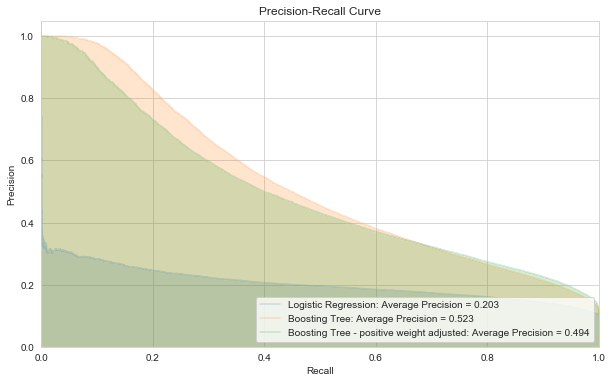

In [39]:
plot_pr(train['pred_lr'], train['label'], label='Logistic Regression')
plot_pr(train['pred_tree'], train['label'], label='Boosting Tree')
plot_pr(train['pred_tree_balanced'], train['label'], label='Boosting Tree - positive weight adjusted')

### Validation set performance

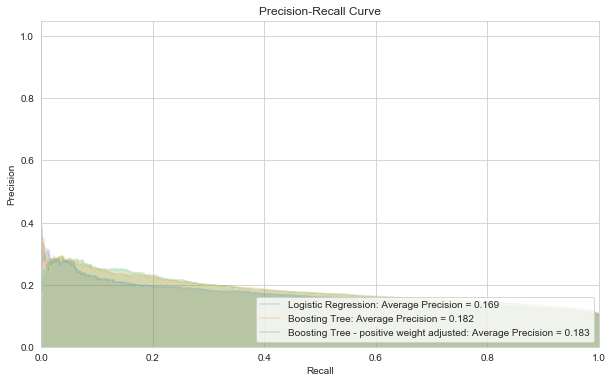

In [40]:
plot_pr(valid['pred_lr'], valid['label'], label='Logistic Regression')
plot_pr(valid['pred_tree'], valid['label'], label='Boosting Tree')
plot_pr(valid['pred_tree_balanced'], valid['label'], label='Boosting Tree - positive weight adjusted')

# Kitchen Sink Model

### Model: 
- XGBoost without adjustment for class imblance
- XGBoost with adjustment for class imblance

### Features:
12 + 32 = 44 features in total
- rating
- user_review_count
- user_average_rating
- restaurant_review_count
- restaurant_average_rating
- punctuation_count
- wordcount
- capitalization_count
- letter_count
- days_since_first_user
- days_since_first_restaurant
- pred_nb
- Word2Vec (vector size=32)

#### ↓ Prediction from MultinomialNB - TFIDF

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [6]:
cv = TfidfVectorizer(binary=False, ngram_range=(1,1), max_df=.5, min_df=.001)
text_data_train = cv.fit_transform(train['review'].tolist())
text_data_valid = cv.transform(valid['review'].tolist())

print(text_data_train.shape)
print(text_data_valid.shape)

text_data = scipy.sparse.vstack([text_data_train, text_data_valid])

(250874, 4701)
(35918, 4701)


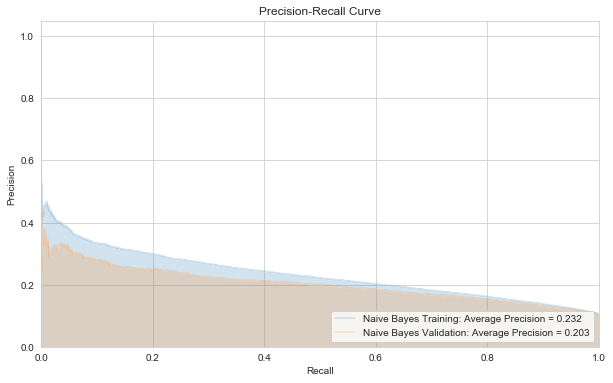

In [10]:
nb = MultinomialNB()
nb.fit(text_data_train, train['label'])

train['pred_nb'] = nb.predict_proba(text_data_train)[:,1]
valid['pred_nb'] = nb.predict_proba(text_data_valid)[:,1]

plot_pr(train['pred_nb'], train['label'], label='Naive Bayes Training')
plot_pr(valid['pred_nb'], valid['label'], label='Naive Bayes Validation')

#### ↓ Word2Vec using Gensim

In [11]:
import gensim
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [12]:
documents_train = [TaggedDocument(doc, [i]) for i, doc in enumerate(train['review'].str.split(" "))]

In [13]:
d2v = Doc2Vec(documents_train, vector_size=32, window=2, min_count=100)

In [14]:
d2v_df_train = train['review'].str.split(" ").apply(lambda x: d2v.infer_vector(x)).apply(pd.Series)
d2v_df_train.columns = ['d2v_' + str(x) for x in d2v_df_train.columns]

In [15]:
d2v_df_valid = valid['review'].str.split(" ").apply(lambda x: d2v.infer_vector(x)).apply(pd.Series)
d2v_df_valid.columns = ['d2v_' + str(x) for x in d2v_df_valid.columns]

In [16]:
d2v_df_valid.head()

,d2v_0,d2v_1,d2v_2,d2v_3,d2v_4,d2v_5,d2v_6,d2v_7,d2v_8,d2v_9,...,d2v_22,d2v_23,d2v_24,d2v_25,d2v_26,d2v_27,d2v_28,d2v_29,d2v_30,d2v_31
0,0.098205,-0.144127,0.008945,-0.103522,-0.196631,-0.244086,-0.043949,-0.118954,-0.064454,-0.153833,...,-0.104804,-0.071833,-0.126842,-0.169352,0.062045,-0.184110,-0.258518,0.152874,0.075649,-0.046798
1,0.072632,-0.216344,-0.019428,-0.048739,-0.156005,0.066588,-0.175601,-0.026110,-0.289058,-0.511859,...,-0.143597,-0.142120,-0.110070,-0.108780,-0.159687,-0.005705,0.036911,0.271796,0.250028,-0.220804
2,0.094849,-0.232136,-0.103408,-0.273766,-0.571657,-0.282201,-0.174839,-0.108568,-0.121851,-0.016906,...,-0.235928,0.099959,-0.129797,0.288737,-0.010579,-0.431333,-0.220822,-0.117090,0.052867,0.050642
3,0.231692,-0.500490,-0.035584,-0.091804,-0.198661,-0.012962,0.033702,-0.090015,-0.055986,-0.127416,...,-0.376139,-0.119057,-0.015358,0.328977,0.037057,0.049057,-0.039976,0.154261,0.120991,-0.132501
4,0.106079,-0.064452,-0.179282,-0.048026,-0.101172,-0.184103,0.010854,-0.095300,-0.273206,-0.271330,...,-0.178505,-0.077373,0.034157,-0.179631,0.032667,0.026083,-0.223993,0.225190,0.130237,0.104112


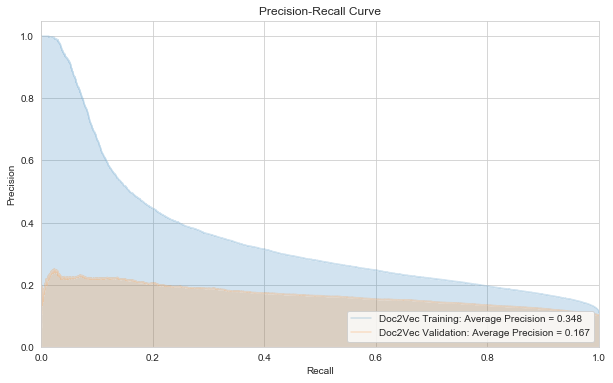

In [20]:
tree_d2v = XGBClassifier()
tree_d2v.fit(d2v_df_train, train['label'])

train['pred_d2v'] = tree_d2v.predict_proba(d2v_df_train)[:,1]
valid['pred_d2v'] = tree_d2v.predict_proba(d2v_df_valid)[:,1]

plot_pr(train['pred_d2v'], train['label'], label='Doc2Vec Training')
plot_pr(valid['pred_d2v'], valid['label'], label='Doc2Vec Validation')

#### ↓ Putting everything together

In [21]:
everything_train = pd.concat([train, d2v_df_train], axis=1)
everything_valid = pd.concat([valid, d2v_df_valid], axis=1)
everything_features = train_features + ['pred_nb'] + d2v_df_train.columns.tolist()
everything_features

['rating',
 'user_review_count',
 'user_average_rating',
 'restaurant_review_count',
 'restaurant_average_rating',
 'punctuation_count',
 'wordcount',
 'capitalization_count',
 'letter_count',
 'days_since_first_user',
 'days_since_first_restaurant',
 'pred_nb',
 'd2v_0',
 'd2v_1',
 'd2v_2',
 'd2v_3',
 'd2v_4',
 'd2v_5',
 'd2v_6',
 'd2v_7',
 'd2v_8',
 'd2v_9',
 'd2v_10',
 'd2v_11',
 'd2v_12',
 'd2v_13',
 'd2v_14',
 'd2v_15',
 'd2v_16',
 'd2v_17',
 'd2v_18',
 'd2v_19',
 'd2v_20',
 'd2v_21',
 'd2v_22',
 'd2v_23',
 'd2v_24',
 'd2v_25',
 'd2v_26',
 'd2v_27',
 'd2v_28',
 'd2v_29',
 'd2v_30',
 'd2v_31']

In [22]:
y_train = train['label']
pos_ratio = (len(y_train)-y_train.sum()) / y_train.sum()

everything_model = XGBClassifier(scale_pos_weight=pos_ratio)
everything_model.fit(everything_train[everything_features], y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=8.716642782447035, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

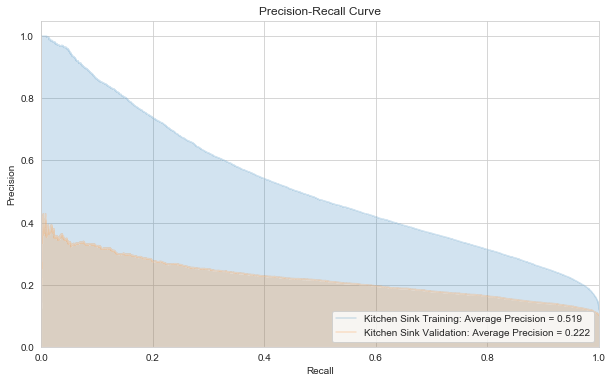

In [23]:
train['pred_everything'] = everything_model.predict_proba(everything_train[everything_features])[:,1]
valid['pred_everything'] = everything_model.predict_proba(everything_valid[everything_features])[:,1]

plot_pr(train['pred_everything'], train['label'], label='Kitchen Sink Training')
plot_pr(valid['pred_everything'], valid['label'], label='Kitchen Sink Validation')